In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import preprocess as pp
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
#from captum.attr import (
#    GradientShap,
#    DeepLift,
#    DeepLiftShap,
#    IntegratedGradients,
#    LayerConductance,
#    NeuronConductance,
#    NoiseTunnel,
#)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses a GPU!')
else:
    device = torch.device('cpu')
    print('The code uses a CPU...')

The code uses a CPU...


In [18]:
task = 'regression'
dataset = 'AP_hex'
radius = 1
(dataset_train, dataset_dev, dataset_test,
     N_fingerprints) = pp.create_datasets(task, dataset, radius, device)

data_train.txt
data_test.txt


In [19]:
print('# of training data samples:', len(dataset_train))
print('# of development data samples:', len(dataset_dev))
print('# of test data samples:', len(dataset_test))

dim=50
layer_hidden=6
layer_output=6
batch_train=32
batch_test=32


# of training data samples: 8999
# of development data samples: 1000
# of test data samples: 6257


In [20]:
class MolecularGraphNeuralNetwork(nn.Module):
    def __init__(self, N_fingerprints, dim, layer_hidden, layer_output):
        super(MolecularGraphNeuralNetwork, self).__init__()
        self.embed_fingerprint = nn.Embedding(N_fingerprints, dim)
        self.W_fingerprint = nn.ModuleList([nn.Linear(dim, dim)
                                            for _ in range(layer_hidden)])
        self.W_output = nn.ModuleList([nn.Linear(dim, dim)
                                       for _ in range(layer_output)])
        if task == 'classification':
            self.W_property = nn.Linear(dim, 2)
        if task == 'regression':
            self.W_property = nn.Linear(dim, 1)

    def pad(self, matrices, pad_value):
        """Pad the list of matrices
        with a pad_value (e.g., 0) for batch processing.
        For example, given a list of matrices [A, B, C],
        we obtain a new matrix [A00, 0B0, 00C],
        where 0 is the zero (i.e., pad value) matrix.
        """
        shapes = [m.shape for m in matrices]
        M, N = sum([s[0] for s in shapes]), sum([s[1] for s in shapes])
        zeros = torch.FloatTensor(np.zeros((M, N))).to(device)
        pad_matrices = pad_value + zeros
        i, j = 0, 0
        for k, matrix in enumerate(matrices):
            m, n = shapes[k]
            pad_matrices[i:i+m, j:j+n] = matrix
            i += m
            j += n
        return pad_matrices

    def update(self, matrix, vectors, layer):
        hidden_vectors = torch.relu(self.W_fingerprint[layer](vectors))
        return hidden_vectors + torch.matmul(matrix, hidden_vectors)

    def sum(self, vectors, axis):
        sum_vectors = [torch.sum(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(sum_vectors)

    def mean(self, vectors, axis):
        mean_vectors = [torch.mean(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(mean_vectors)

    def gnn(self, inputs):

        """Cat or pad each input data for batch processing."""
        fingerprints, adjacencies, molecular_sizes = inputs
        fingerprints = torch.cat(fingerprints)
        adjacencies = self.pad(adjacencies, 0)

        """GNN layer (update the fingerprint vectors)."""
        fingerprint_vectors = self.embed_fingerprint(fingerprints)
        for l in range(layer_hidden):
            hs = self.update(adjacencies, fingerprint_vectors, l)
            fingerprint_vectors = F.normalize(hs, 2, 1)  # normalize.

        """Molecular vector by sum or mean of the fingerprint vectors."""
        molecular_vectors = self.sum(fingerprint_vectors, molecular_sizes)
        # molecular_vectors = self.mean(fingerprint_vectors, molecular_sizes)

        return molecular_vectors

    def mlp(self, vectors):
        """Classifier or regressor based on multilayer perceptron."""
        for l in range(layer_output):
            vectors = torch.relu(self.W_output[l](vectors))
        outputs = self.W_property(vectors)
        return outputs

    def forward_classifier(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_labels = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_scores = self.mlp(molecular_vectors)
            loss = F.cross_entropy(predicted_scores, correct_labels)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_scores = self.mlp(molecular_vectors)
            predicted_scores = predicted_scores.to('cpu').data.numpy()
            predicted_scores = [s[1] for s in predicted_scores]
            correct_labels = correct_labels.to('cpu').data.numpy()
            return predicted_scores, correct_labels

    def forward_regressor(self, data_batch, train):

        inputs = data_batch[:-1]
        correct_values = torch.cat(data_batch[-1])

        if train:
            molecular_vectors = self.gnn(inputs)
            predicted_values = self.mlp(molecular_vectors)
            loss = F.mse_loss(predicted_values, correct_values)
            return loss
        else:
            with torch.no_grad():
                molecular_vectors = self.gnn(inputs)
                predicted_values = self.mlp(molecular_vectors)
            predicted_values = predicted_values.to('cpu').data.numpy()
            correct_values = correct_values.to('cpu').data.numpy()
            molecular_vectors = molecular_vectors.to('cpu').data.numpy()
            predicted_values = np.concatenate(predicted_values)
            correct_values = np.concatenate(correct_values)
            molecular_vectors = np.concatenate(molecular_vectors)
            return predicted_values, correct_values

In [21]:
torch.manual_seed(1234)
model = MolecularGraphNeuralNetwork(
        N_fingerprints, dim, layer_hidden, layer_output).to(device)

print('# of model parameters:',
      sum([np.prod(p.size()) for p in model.parameters()]))

# of model parameters: 32551


In [22]:
model.load_state_dict(torch.load('BestModel_ub_pent.pt'))
model.eval()

/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_13108/2033818886.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('BestModel_u

MolecularGraphNeuralNetwork(
  (embed_fingerprint): Embedding(38, 50)
  (W_fingerprint): ModuleList(
    (0-5): 6 x Linear(in_features=50, out_features=50, bias=True)
  )
  (W_output): ModuleList(
    (0-5): 6 x Linear(in_features=50, out_features=50, bias=True)
  )
  (W_property): Linear(in_features=50, out_features=1, bias=True)
)

In [23]:
class Trainer(object):
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, dataset, x):
        np.random.shuffle(dataset)
        N = x
        loss_total = 0
        for i in range(0, N, batch_train):
            data_batch = list(zip(*dataset[i:i+batch_train]))
            if task == 'classification':
                loss = self.model.forward_classifier(data_batch, train=True)
            if task == 'regression':
                loss = self.model.forward_regressor(data_batch, train=True)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_total += loss.item()
        return loss_total


class Tester(object):
    def __init__(self, model):
        self.model = model

    def test_classifier(self, dataset):
        N = len(dataset)
        P, C = [], []
        for i in range(0, N, batch_test):
            data_batch = list(zip(*dataset[i:i+batch_test]))
            predicted_scores, correct_labels = self.model.forward_classifier(
                                               data_batch, train=False)
            P.append(predicted_scores)
            C.append(correct_labels)
        AUC = roc_auc_score(np.concatenate(C), np.concatenate(P))
        return AUC

    def test_regressor(self, dataset):
        N = len(dataset)
        SAE = 0  # sum absolute error.
        MSE = 0  # mean square error.
        for i in range(0, N, batch_test):
            data_batch = list(zip(*dataset[i:i+batch_test]))
            predicted_values, correct_values = self.model.forward_regressor(
                                               data_batch, train=False)
            SAE += sum(np.abs(predicted_values-correct_values))
            MSE += sum(np.square(predicted_values-correct_values))
        MAE = SAE / N  # mean absolute error.
        RMSE = np.sqrt(MSE/N)
        return MAE,RMSE

    def save_result(self, result, filename):
        with open(filename, 'a') as f:
            f.write(result + '\n')


In [24]:
decay_interval = 1
iteration = 5
lr_decay = 0.99
lr = 1e-4

rmse_dis = {} 

for x in range(0, len(dataset_train), int(len(dataset_train)/45)):
    torch.manual_seed(1234)
    model.load_state_dict(torch.load('BestModel_ub_pent.pt'))

    trainer = Trainer(model)
    tester = Tester(model)
    min_rmse = 2
    for epoch in range(iteration):

            epoch += 1
            if epoch % decay_interval == 0:
                trainer.optimizer.param_groups[0]['lr'] *= lr_decay

            loss_train = trainer.train(dataset_train[0:x], x)

            if task == 'classification':
                prediction_dev = tester.test_classifier(dataset_dev)
                prediction_test = tester.test_classifier(dataset_test)
            if task == 'regression':
                prediction_dev_mae, prediction_dev_rmse = tester.test_regressor(dataset_dev)
                prediction_test_mae, prediction_test_rmse = tester.test_regressor(dataset_test)

            min_rmse = min(min_rmse, prediction_test_rmse)
            
    rmse_dis[x] = min_rmse
    print(f'Training for {x} peptides gives rmse of {min_rmse}')


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_13108/638239658.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('BestModel_u

Training for 0 peptides gives rmse of 0.3064887821674347
Training for 199 peptides gives rmse of 0.17522753775119781
Training for 398 peptides gives rmse of 0.14999374747276306
Training for 597 peptides gives rmse of 0.13884548842906952
Training for 796 peptides gives rmse of 0.12348517775535583
Training for 995 peptides gives rmse of 0.12301154434680939
Training for 1194 peptides gives rmse of 0.10929792374372482
Training for 1393 peptides gives rmse of 0.10505441576242447
Training for 1592 peptides gives rmse of 0.09881241619586945
Training for 1791 peptides gives rmse of 0.09192128479480743
Training for 1990 peptides gives rmse of 0.09624436497688293
Training for 2189 peptides gives rmse of 0.09172355383634567
Training for 2388 peptides gives rmse of 0.08133155852556229
Training for 2587 peptides gives rmse of 0.08671228587627411
Training for 2786 peptides gives rmse of 0.09427262842655182
Training for 2985 peptides gives rmse of 0.08098514378070831
Training for 3184 peptides gives 

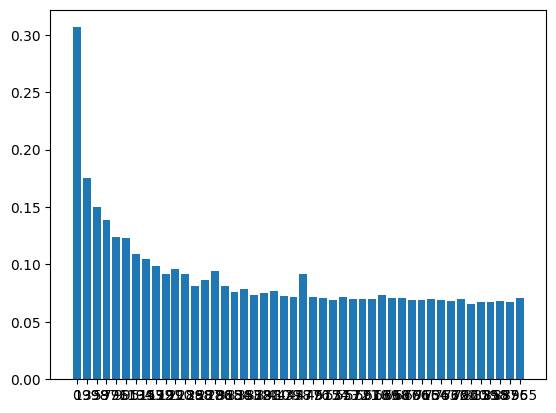

In [31]:
p = []
r = []
for i in rmse_dis:
    p.append(str(i)) 
    r.append(rmse_dis[i])
plt.bar(p, r)
plt.show()

In [44]:
N = len(dataset_dev)
D = []
V = []
for i in range(0, N, batch_test):
    data_batch = list(zip(*dataset_dev[i:i+batch_test]))
    predicted_scores, correct_scores = model_hex.forward_regressor(
                                       data_batch, train=False)
    D.append(np.abs(predicted_scores-correct_scores))
    #V.append(molecular_vectors)

In [45]:
diff = []
for i in range(len(D)):
    for j in range(len(D[i])):
        diff.append(D[i][j])

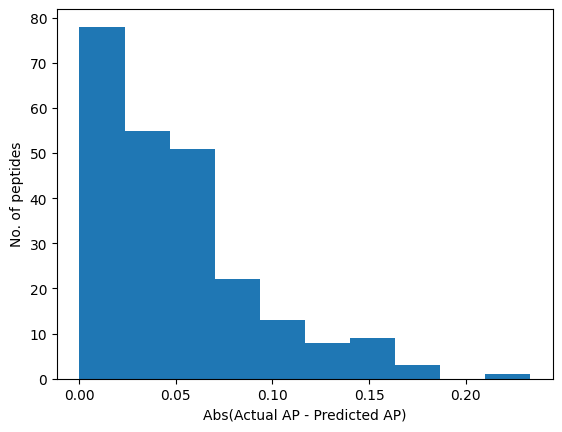

In [46]:
plt.hist(diff)
plt.xlabel('Abs(Actual AP - Predicted AP)')
plt.ylabel('No. of peptides')
plt.show()  #model : dipep, data used to pred : tetra